In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch.nn as nn
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

# **Loading and Preparing Data**

In [ ]:
df = yf.download("BTC-USD", start="2000-01-01", end="2025-07-31")
df.dropna(inplace=True)

volume = df["Volume"].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
volume_scaled = scaler.fit_transform(volume)
volume_scaled = volume_scaled[1:]

open_price = df["Open"].values
movement = np.where(open_price[1:] > open_price[:-1], 1, 0)

data = np.column_stack((volume_scaled, movement))

/tmp/ipython-input-3227710097.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("BTC-USD", start="2000-01-01", end="2025-07-31")
[*********************100%***********************]  1 of 1 completed


In [ ]:
data.shape

(3969, 2)

In [ ]:
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i:(i+seq_len)]
        y = data[i+seq_len, -1]
        xs.append(x)
        ys.append(y)

    X = torch.tensor(xs, dtype=torch.float32)
    y = torch.tensor(ys, dtype=torch.float32)
    return X, y

In [ ]:
def make_dataloaders(data, seq_len=30, batch_size=32, split_ratio=(0.7, 0.2, 0.1)):
    X, y = create_sequences(data, seq_len)

    N = len(X)
    n_train = int(N * split_ratio[0])
    n_val   = int(N * split_ratio[1])

    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val     = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test, y_test   = X[n_train+n_val:], y[n_train+n_val:]

    train_set = TensorDataset(X_train, y_train)
    val_set   = TensorDataset(X_val, y_val)
    test_set  = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, drop_last=True)
    val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, val_loader, test_loader

In [ ]:
train_set, val_set, test_set = make_dataloaders(data)

/tmp/ipython-input-3661269176.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  X = torch.tensor(xs, dtype=torch.float32)


In [ ]:
for i, (x_batch, y_batch) in enumerate(train_set):
    print(f"Batch {i}: x={x_batch.shape}, y={y_batch.shape}")
    break

Batch 0: x=torch.Size([32, 30, 2]), y=torch.Size([32])


# **Transformer**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, head_numbers):
      super(MultiHeadAttention, self).__init__()
      self.d_model = d_model
      self.head_numbers = head_numbers
      self.wq = nn.Linear(d_model, d_model*head_numbers)
      self.wk = nn.Linear(d_model, d_model*head_numbers)
      self.wv = nn.Linear(d_model, d_model*head_numbers)
      self.dense = nn.Linear(d_model*head_numbers, d_model)

  def forward(self, x, mask):
      B, S, _ = x.shape
      Q = self.wq(x).reshape(B, S, self.head_numbers, self.d_model).permute(0, 2, 1, 3)
      K = self.wk(x).reshape(B, S, self.head_numbers, self.d_model).permute(0, 2, 1, 3)
      V = self.wv(x).reshape(B, S, self.head_numbers, self.d_model).permute(0, 2, 1, 3)
      attention_scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.d_model)


      if mask is not None:
        mask = torch.ones((S, S), device=device)
        mask = torch.triu(mask, diagonal=1)
        attention_scores += (mask * -1e9)

      attention_weights = nn.Softmax(dim=-1)(attention_scores)
      scaled_attention = torch.matmul(attention_weights, V)
      concat_attention = scaled_attention.permute(0, 2, 1, 3).reshape(B, S, self.head_numbers * self.d_model)
      output = self.dense(concat_attention)
      return output, attention_weights

In [ ]:
class TransformerLayer(nn.Module):
    def __init__(self, d_model, head_numbers, mlp_dim, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.dropout_rate = dropout_rate
        self.mlp_hidden = nn.Linear(d_model, mlp_dim)
        self.mlp_out = nn.Linear(mlp_dim, d_model)
        self.layernorm1 = nn.LayerNorm(d_model, eps=1e-9)
        self.layernorm2 = nn.LayerNorm(d_model, eps=1e-9)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.mha = MultiHeadAttention(d_model, head_numbers)

    def forward(self, x, mask):
        attn, attn_weights = self.mha(x, mask)
        attn = self.dropout1(attn)
        attn = self.layernorm1(attn + x)
        mlp_act = torch.sigmoid(self.mlp_hidden(attn))
        mlp_act = self.mlp_out(mlp_act)
        mlp_act = self.dropout2(mlp_act)
        output = self.layernorm2(mlp_act + attn)
        return output, attn_weights

In [ ]:
def positional_encoding(d_model, seq_length, device=device):
  p = np.arange(seq_length)[:, np.newaxis]
  i =  np.arange(d_model)[np.newaxis, :]
  argument = p / np.power(10000, (2 * (i // 2)) / np.float32(d_model))

  argument[:, 0::2] = np.sin(argument[:, 0::2])
  argument[:, 1::2] = np.cos(argument[:, 1::2])
  pos_encoding = argument[np.newaxis, ...]
  return torch.tensor(pos_encoding, device=device)

In [ ]:
class Transformer(nn.Module):
    def __init__(self, seq_length, num_layers, d_model, head_numbers, hidden_mlp_dim, inp_features, out_features, dropout_rate):
        super(Transformer, self).__init__()
        self.sqrt_D = math.sqrt(d_model)
        self.d_model = d_model
        self.num_layers = num_layers
        self.input_projection = nn.Linear(inp_features, d_model)
        self.output_projection = nn.Linear(seq_length*d_model, out_features)
        self.pos_encoding = positional_encoding(d_model, seq_length)
        self.dec_layers = nn.ModuleList([TransformerLayer(d_model, head_numbers, hidden_mlp_dim, dropout_rate=dropout_rate) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x, mask):
        B, S, inp_features = x.shape
        attention_weights = {}
        x = self.input_projection(x)
        x *= self.sqrt_D
        x += self.pos_encoding[:, :S, :]
        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block = self.dec_layers[i](x, mask)
            attention_weights['decoder_layer{}'.format(i + 1)] = block

        x = x.reshape(B, S * self.d_model)
        x = self.output_projection(x)
        return x, attention_weights

In [ ]:
transformer = Transformer(seq_length =30, num_layers=4, d_model=10, head_numbers=4, hidden_mlp_dim=32, inp_features=2, out_features=2, dropout_rate=0.1).to(device)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001)

In [ ]:
param_sizes = [p.numel() for p in transformer.parameters()]
print(f"number of weight/biases matrices: {len(param_sizes)} "
      f"for a total of {np.sum(param_sizes)} parameters ")

number of weight/biases matrices: 68 for a total of 10440 parameters 


In [ ]:
# to see the output shape of transformer compared to labels
for x, y in train_set:
  out, _ = transformer(x, mask=True)
  print(out.shape)
  print(y.shape)
  break

torch.Size([32, 2])
torch.Size([32])


In [ ]:
from tqdm import tqdm

criterion = torch.nn.CrossEntropyLoss()
n_epochs = 100
losses, val_losses = [], []

patience = 10
best_val_loss = float('inf')
counter = 0

for e in tqdm(range(n_epochs)):

    # --- Training ---
    transformer.train()
    sum_train_loss = 0.0
    for x, y in train_set:
        x, y = x.float().to(device), y.long().to(device)

        optimizer.zero_grad()
        out, _ = transformer(x, mask=True)

        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        sum_train_loss += loss.item()
    train_loss = sum_train_loss / len(train_set)
    losses.append(train_loss)

    # --- Validation ---
    transformer.eval()
    sum_val_loss = 0.0
    with torch.no_grad():
        for x, y in val_set:
            x, y = x.float().to(device), y.long().to(device)
            out, _ = transformer(x, mask=True)
            loss = criterion(out, y)
            sum_val_loss += loss.item()

    val_loss = sum_val_loss / len(val_set)
    val_losses.append(val_loss)

    print(f"Epoch {e+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # --- Early Stopping Check ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(transformer.state_dict(), 'best_transformer.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {e+1} epochs.")
            break

  1%|          | 1/100 [00:05<09:51,  5.97s/it]

Epoch 1/100 | Train Loss: 0.7039 | Val Loss: 0.6930


  2%|▏         | 2/100 [00:12<10:01,  6.14s/it]

Epoch 2/100 | Train Loss: 0.6988 | Val Loss: 0.6924


  3%|▎         | 3/100 [00:15<07:34,  4.68s/it]

Epoch 3/100 | Train Loss: 0.7001 | Val Loss: 0.6922


  4%|▍         | 4/100 [00:18<06:23,  3.99s/it]

Epoch 4/100 | Train Loss: 0.6943 | Val Loss: 0.6926


  5%|▌         | 5/100 [00:21<05:44,  3.62s/it]

Epoch 5/100 | Train Loss: 0.6963 | Val Loss: 0.6924


  6%|▌         | 6/100 [00:24<05:44,  3.66s/it]

Epoch 6/100 | Train Loss: 0.6961 | Val Loss: 0.6922


  7%|▋         | 7/100 [00:27<05:21,  3.45s/it]

Epoch 7/100 | Train Loss: 0.6934 | Val Loss: 0.6923


  8%|▊         | 8/100 [00:30<05:03,  3.29s/it]

Epoch 8/100 | Train Loss: 0.6925 | Val Loss: 0.6921


  9%|▉         | 9/100 [00:33<04:52,  3.21s/it]

Epoch 9/100 | Train Loss: 0.6922 | Val Loss: 0.6921


 10%|█         | 10/100 [00:37<05:02,  3.36s/it]

Epoch 10/100 | Train Loss: 0.6922 | Val Loss: 0.6921


 11%|█         | 11/100 [00:40<04:53,  3.30s/it]

Epoch 11/100 | Train Loss: 0.6919 | Val Loss: 0.6920


 12%|█▏        | 12/100 [00:43<04:42,  3.21s/it]

Epoch 12/100 | Train Loss: 0.6939 | Val Loss: 0.6920


 13%|█▎        | 13/100 [00:46<04:32,  3.14s/it]

Epoch 13/100 | Train Loss: 0.6912 | Val Loss: 0.6918


 14%|█▍        | 14/100 [00:50<04:42,  3.28s/it]

Epoch 14/100 | Train Loss: 0.6917 | Val Loss: 0.6919


 15%|█▌        | 15/100 [00:53<04:34,  3.23s/it]

Epoch 15/100 | Train Loss: 0.6909 | Val Loss: 0.6914


 16%|█▌        | 16/100 [00:56<04:25,  3.16s/it]

Epoch 16/100 | Train Loss: 0.6917 | Val Loss: 0.6915


 17%|█▋        | 17/100 [00:59<04:18,  3.12s/it]

Epoch 17/100 | Train Loss: 0.6908 | Val Loss: 0.6914


 18%|█▊        | 18/100 [01:03<04:29,  3.28s/it]

Epoch 18/100 | Train Loss: 0.6912 | Val Loss: 0.6913


 19%|█▉        | 19/100 [01:06<04:23,  3.25s/it]

Epoch 19/100 | Train Loss: 0.6896 | Val Loss: 0.6912


 20%|██        | 20/100 [01:09<04:12,  3.16s/it]

Epoch 20/100 | Train Loss: 0.6914 | Val Loss: 0.6911


 21%|██        | 21/100 [01:12<04:03,  3.09s/it]

Epoch 21/100 | Train Loss: 0.6931 | Val Loss: 0.6911


 22%|██▏       | 22/100 [01:15<04:13,  3.25s/it]

Epoch 22/100 | Train Loss: 0.6893 | Val Loss: 0.6909


 23%|██▎       | 23/100 [01:18<04:08,  3.23s/it]

Epoch 23/100 | Train Loss: 0.6882 | Val Loss: 0.6909


 24%|██▍       | 24/100 [01:21<03:59,  3.16s/it]

Epoch 24/100 | Train Loss: 0.6878 | Val Loss: 0.6907


 25%|██▌       | 25/100 [01:24<03:51,  3.08s/it]

Epoch 25/100 | Train Loss: 0.6898 | Val Loss: 0.6908


 26%|██▌       | 26/100 [01:28<03:57,  3.21s/it]

Epoch 26/100 | Train Loss: 0.6896 | Val Loss: 0.6908


 27%|██▋       | 27/100 [01:31<03:57,  3.25s/it]

Epoch 27/100 | Train Loss: 0.6877 | Val Loss: 0.6909


 28%|██▊       | 28/100 [01:34<03:48,  3.17s/it]

Epoch 28/100 | Train Loss: 0.6881 | Val Loss: 0.6911


 29%|██▉       | 29/100 [01:37<03:45,  3.17s/it]

Epoch 29/100 | Train Loss: 0.6865 | Val Loss: 0.6911


 30%|███       | 30/100 [01:42<04:05,  3.51s/it]

Epoch 30/100 | Train Loss: 0.6891 | Val Loss: 0.6911


 31%|███       | 31/100 [01:45<03:52,  3.37s/it]

Epoch 31/100 | Train Loss: 0.6891 | Val Loss: 0.6911


 32%|███▏      | 32/100 [01:48<03:40,  3.24s/it]

Epoch 32/100 | Train Loss: 0.6866 | Val Loss: 0.6911


 33%|███▎      | 33/100 [01:51<03:38,  3.26s/it]

Epoch 33/100 | Train Loss: 0.6873 | Val Loss: 0.6912


 33%|███▎      | 33/100 [01:55<03:53,  3.49s/it]

Epoch 34/100 | Train Loss: 0.6871 | Val Loss: 0.6912
Early stopping triggered after 34 epochs.


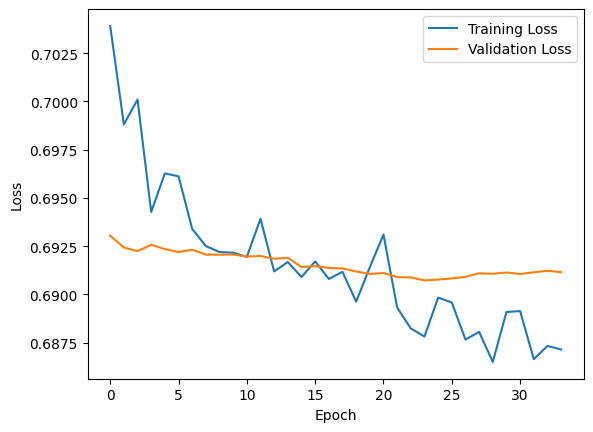

In [ ]:
plt.plot(losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
transformer.eval()
preds, actuals = [], []

with torch.no_grad():
    for x, y in test_set:
        x = x.float().to(device)
        y = y.long().to(device)

        out, _ = transformer(x, mask=True)
        pred = torch.argmax(out, dim=-1)
        preds.append(pred.cpu().numpy())
        actuals.append(y.cpu().numpy())

# Convert to arrays
preds = np.concatenate(preds, axis=0)
actuals = np.concatenate(actuals, axis=0)

In [ ]:
print(f'The model correctly predicted {np.sum(preds == actuals)} times out of {len(actuals)} which means accuracy of {np.sum(preds == actuals)/len(actuals)} %')

The model correctly predicted 195 times out of 384 which means accuracy of 0.5078125 %


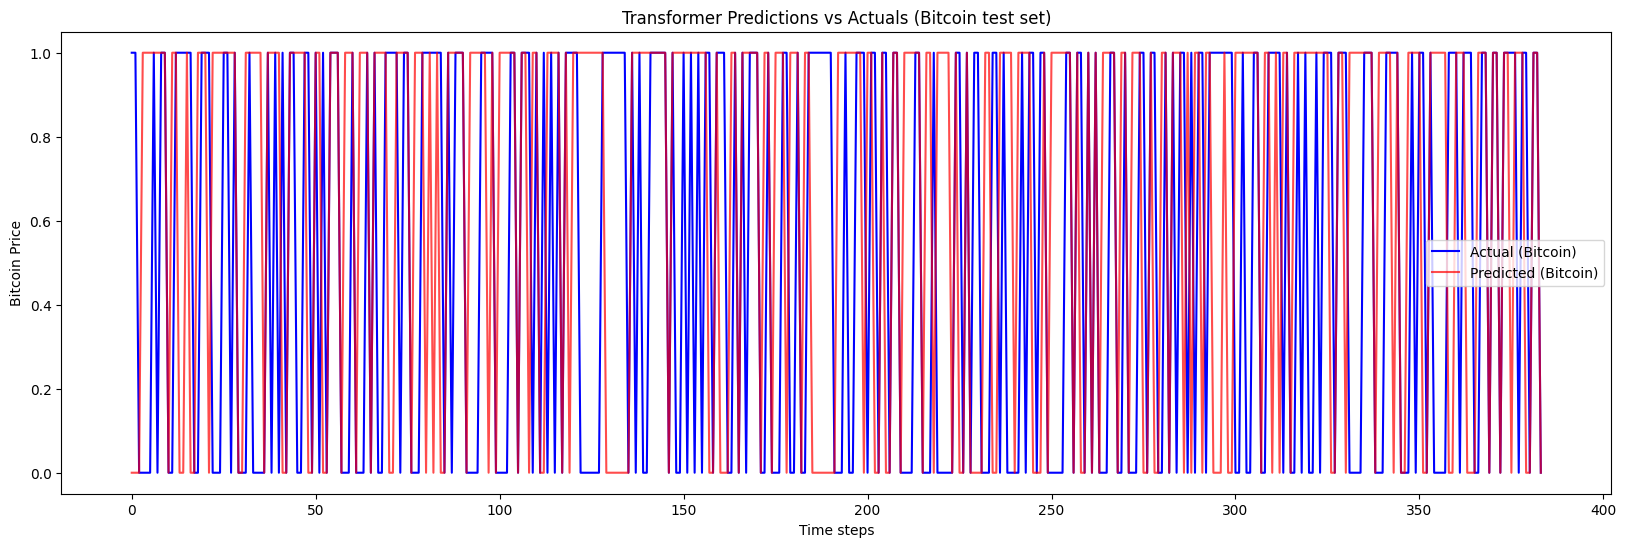

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(actuals, label="Actual (Bitcoin)", color="blue")
plt.plot(preds, label="Predicted (Bitcoin)", color="red", alpha=0.7)
plt.title("Transformer Predictions vs Actuals (Bitcoin test set)")
plt.xlabel("Time steps")
plt.ylabel("Bitcoin Price")
plt.legend()
plt.show()